In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sim_functions import *

from tqdm import tqdm

from scipy.optimize import curve_fit

Using cupy


In [2]:
nx = 100
ny = 100
steps = 5000
output_stride = 500

In [3]:
molecular_weights = np.array([1,80])
n_species = len(molecular_weights)
multiplier = 55

Bss = multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[1])
D_lbm = 1/Bss
print('Predict diffusion constant = ', D_lbm)

phi_1 = 0.78
phi_2 = phi_1 * molecular_weights[0]/molecular_weights[1]
phis = np.array([phi_1, phi_2])
phis = xp.array(phis)

predict_lambda = (phi_1 /3) * multiplier * 1/np.sqrt(1/molecular_weights[0] + 1/molecular_weights[0])
relaxation = predict_lambda/(1+predict_lambda/2)
viscosity_kinematic = 1/3 * (1/relaxation - 0.5)
print('viscosity_kinematic = ',viscosity_kinematic)

Predict diffusion constant =  0.01829510163408919
viscosity_kinematic =  0.03296535110426797


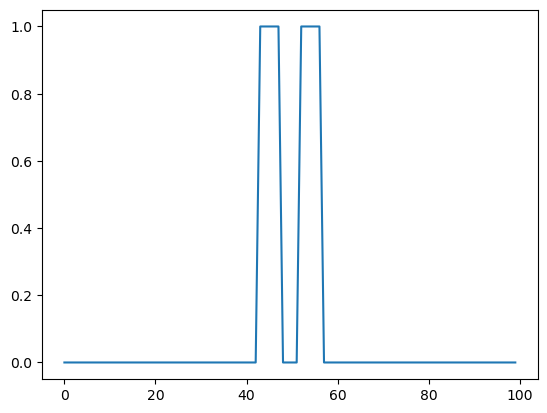

In [4]:
absorption_coefficient = 100

non_absorb_mask = xp.zeros(nx)
gap = 5
width = 5
non_absorb_mask[nx//2 - gap//2 - width: nx//2- gap//2] = True
non_absorb_mask[nx//2 + gap//2 : nx//2 + gap//2 + width] = True

plt.plot(to_numpy(non_absorb_mask))

In [5]:
#bottom boundary
b1 = xp.array([absorption_coefficient, 0, 0]) # 1 / absorption
b2 = xp.array([1, 1])
b3 = xp.array([0, 89.1])/2 # stable concentration
reflection_boundary = np.array([0, 1]) # which component has no-slip wall BC

bc_bottom = (b1, b2, b3, reflection_boundary)

# top boundary
b1 = xp.array([0, 0])
b2 = xp.array([1, 1])
b3 = xp.array([0.9, 89.1])/2
reflection_boundary = np.array([0, 0, 0])

bc_top = (b1, b2, b3, reflection_boundary)

In [6]:
lbm_config = lbm_parameters(
    nx=nx,
    ny=ny,
    steps=steps,
    output_interval=output_stride,
    molecular_weights=xp.array(molecular_weights),
    multiplier=multiplier,
    phis=xp.array(phis),
    non_absorb_mask=non_absorb_mask,
    bc_bottom=bc_bottom,
    bc_top=bc_top,
)

In [7]:
vx = 0.003
total_pressure = 1
partial_pressure = xp.array([0.98, 0.02])

ly = ny
y_coord = xp.linspace(0.0, ly, ny)
k = 2*xp.pi /ly
velocity_profile = xp.sin(k*y_coord) * vx

ux_s = xp.ones((n_species, nx, ny), dtype=xp.float32) * velocity_profile[None, None, :]
uy_s = xp.zeros((n_species, nx, ny), dtype=xp.float32)

rho_s = xp.zeros((n_species, nx,ny))
for s in range(n_species):
    rho_s[s,:,:] = 3* partial_pressure[s] * xp.ones((nx,ny))

f = xp.zeros((n_species, 9, nx, ny), dtype=DTYPE)
feq = equilibrium(f, rho_s, lbm_config, ux_s, uy_s)
f = feq

In [8]:
def main(f, lbm_config):
    velocity_field = []
    for step in tqdm(range(lbm_config.steps + 1)):
        if step % output_stride == 0:
            
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, lbm_config)
            ux_s = to_numpy(ux_s).astype(np.float32)
            uy_s = to_numpy(uy_s).astype(np.float32)
            velocity_field.append((ux_s, uy_s))

            
        if step == steps:
            break
        f = bgk_step(f, lbm_config, lattice_stream)
        
    return np.array(velocity_field)

In [9]:
profiles = main(f, lbm_config)

100%|█████████▉| 5000/5001 [00:53<00:00, 92.94it/s]


In [10]:
velocity_field = profiles

In [11]:
print(velocity_field.shape)
# frames, components, species, nx, ny

vx_profile = velocity_field[:, 0, 0, nx//2, :]

(11, 2, 2, 100, 100)


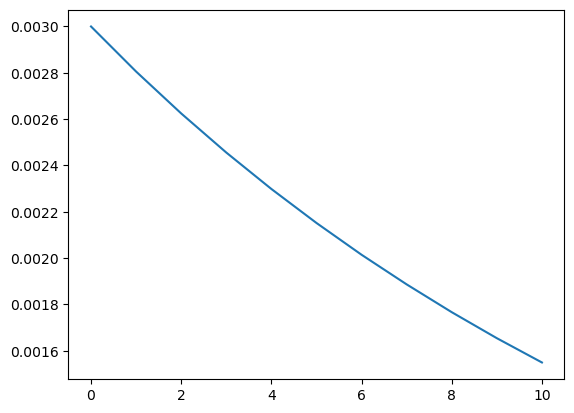

In [12]:
max_velocity_decay_profile = np.max(vx_profile, axis=1)
plt.plot(max_velocity_decay_profile)

In [13]:
ly = ny
k = 2*xp.pi /ly
i = len(max_velocity_decay_profile)-1
t = i * output_stride
mu = -np.log(max_velocity_decay_profile[i]/max_velocity_decay_profile[0])/(t* k**2)
print(mu)

0.033456072314352776


0.03356728632511482


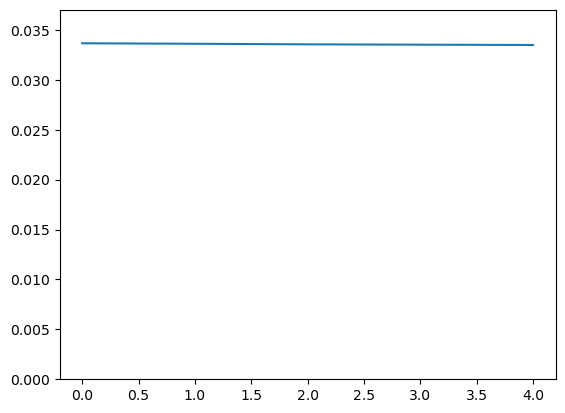

In [14]:
mu_lsit = []
for i in range(5, len(max_velocity_decay_profile)-1):
    t = i * output_stride
    mu = -np.log(max_velocity_decay_profile[i]/max_velocity_decay_profile[0])/(t* k**2)
    mu_lsit.append(mu)
plt.plot(mu_lsit)
plt.ylim([0, 1.1*np.max(mu_lsit)])
print(np.mean(mu_lsit))